# Query SnowEx database for the data we want
* Seth Vanderwilt
* coldfusion GPR-LiDAR
* 7/12/22

## Imports (from https://snowex.hackweek.io/tutorials/core-datasets/03_database_preview.html)

In [1]:
# standard imports
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt 
import datetime

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas, raster_to_rasterio
from snowexsql.db import get_table_attributes

from sqlalchemy.sql import func
from geoalchemy2.types import Raster

import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon
from ipyleaflet import GeoData, LayersControl

import numpy as np
from rasterio.plot import show
import shapely.geometry

from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc
import rioxarray

In [2]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


## Queries to see which kinds of data we have available

In [3]:
# from https://snowex.hackweek.io/tutorials/database/2_database_structure.html



# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))


These are the available columns in the table:
 
* date
* date_accessed
* doi
* easting
* elevation
* equipment
* geom
* instrument
* latitude
* longitude
* metadata
* northing
* observers
* registry
* site_id
* site_name
* time
* time_created
* time_updated
* type
* units
* utm_zone
* value
* version_number



In [41]:
# session.query(PointData.site_id).distinct().all() # None
# session.query(PointData.registry).distinct().all() # registry fails for some reason?
session.query(PointData.doi).distinct().all()

[('https://doi.org/10.5067/WE9GI1GVMQF6',),
 (None,),
 ('https://doi.org/10.5067/Q2LFK0QSVGS2',),
 ('https://doi.org/10.5067/S5EGFLCIAB18',),
 ('https://doi.org/10.5067/9IA978JIACAR',)]

In [42]:
query = session.query(PointData.type)
query = query.filter(PointData.doi == "https://doi.org/10.5067/Q2LFK0QSVGS2")
types = query.distinct().all()
types

[('depth',), ('swe',), ('two_way_travel',)]

In [20]:
point_site_names = session.query(PointData.site_name).distinct().all()
point_site_names # [(None,), ('Grand Mesa',)]

[(None,), ('Grand Mesa',)]

In [19]:
point_observers = session.query(PointData.observers).distinct().all() # Tate Meehan
point_observers

[('Catherine Breen, Cassie Lumbrazo',),
 (None,),
 ('Ryan Webb',),
 ('Randall Bonnell',),
 ('Tate Meehan',)]

### GPR is point data, so let's query the database to see which point data corresponds to Grand Mesa GPR

In [ ]:
session.query(PointData.latitude)



In [15]:
# Grab all Point data instruments from our date
point_instruments = session.query(PointData.instrument).distinct().all()
point_type = session.query(PointData.type).distinct().all()


# Clean up point data (i.e. remove tuple)
point_instruments_list = [p[0] for p in point_instruments if p[0] is not None]
point_instruments = ", ".join(point_instruments_list)
point_type_list = [p[0] for p in point_type]
point_type = ", ".join(point_type_list)
print('Point data are: %s, with the following list of parameters: %s' %(point_instruments, point_type))


Point data are: Mala 1600 MHz GPR, Mala 800 MHz GPR, pulse EKKO Pro multi-polarization 1 GHz GPR, pit ruler, mesa, magnaprobe, camera, with the following list of parameters: swe, depth, two_way_travel


Looking at https://nsidc.org/data/snowex/data_summaries we see that in 2020 there are some GPR datasets:
* BSU Grand Mesa **what we want to start, appears to be "pulse EKKO Pro multi-polarization 1 GHz GPR"**
    - https://nsidc.org/data/SNEX20_BSU_GPR/versions/1
* CSU Cameron Pass
* NMU Jemez

In [23]:
bsu_gpr_instrument_name = "pulse EKKO Pro multi-polarization 1 GHz GPR"

In [29]:
query = session.query(PointData.observers)
# fixed bug: have to do `query = query.filter(...)` to modify the query
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

bsu_gpr_observer = query.distinct().all()
bsu_gpr_observer

# From this, we see that Tate was not the only one out there collecting GPR data with the BSU GPR
# observers are [('Randall Bonnell',), ('Tate Meehan',)]

[('Randall Bonnell',), ('Tate Meehan',)]

In [32]:
query = session.query(PointData.date)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

bsu_gpr_dates = query.distinct().all()
bsu_gpr_dates

[(datetime.date(2020, 2, 4),),
 (datetime.date(2020, 2, 9),),
 (datetime.date(2020, 2, 6),),
 (datetime.date(2020, 2, 7),),
 (datetime.date(2020, 2, 8),),
 (datetime.date(2020, 1, 28),),
 (datetime.date(2020, 1, 29),)]

In [ ]:
# date_range = [dt + i * datetime.timedelta(days=1) for i in [-1, 0, 1]]
# qry = qry.filter(PointData.date.in_(date_range))

In [63]:
# Took 5-10 seconds


query = session.query(PointData)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)
query = query.distinct().order_by(func.random()).limit(100) #all()

bsu_gpr_sample = query_to_geopandas(query, engine)
bsu_gpr_sample

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,easting,elevation,utm_zone,geom,time,site_id,version_number,equipment,value,random_1
0,Grand Mesa,2020-01-28,2022-07-05 16:50:30.058972+00:00,None,3085937,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,swe,mm,...,743673.905030,None,12,POINT (743673.905 4324591.633),23:07:15.217000+00:00,None,None,None,299.270698,4.280334e-09
1,Grand Mesa,2020-02-04,2022-07-05 16:50:30.058972+00:00,None,3699010,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,swe,mm,...,745610.767031,None,12,POINT (745610.767 4321298.760),21:31:54.533000+00:00,None,None,None,192.863339,2.507623e-07
2,Grand Mesa,2020-02-04,2022-07-05 16:40:53.274742+00:00,None,1127751,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,745461.833031,None,12,POINT (745461.833 4321943.337),21:08:57.983000+00:00,None,None,None,7.900000,3.944879e-07
3,Grand Mesa,2020-01-28,2022-07-05 16:45:41.402741+00:00,None,1741469,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,742666.800029,None,12,POINT (742666.800 4323460.057),21:48:04.350000+00:00,None,None,None,114.495098,7.319686e-07
4,Grand Mesa,2020-01-28,2022-07-05 16:40:53.274742+00:00,None,527761,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,743514.708029,None,12,POINT (743514.708 4324252.028),22:51:22.333000+00:00,None,None,None,8.500000,7.489761e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Grand Mesa,2020-01-28,2022-07-05 16:50:30.058972+00:00,None,2918451,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,swe,mm,...,743364.956029,None,12,POINT (743364.956 4324124.936),20:40:46.883000+00:00,None,None,None,259.367938,2.073056e-05
96,Grand Mesa,2020-01-28,2022-07-05 16:40:53.274742+00:00,None,247669,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,743192.822029,None,12,POINT (743192.822 4324192.973),18:45:52.083000+00:00,None,None,None,8.000000,2.085991e-05
97,Grand Mesa,2020-02-06,2022-07-07 19:57:21.141883+00:00,None,4021229,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,745473.457456,None,12,POINT (745473.457 4322492.650),None,None,None,None,89.546131,2.087798e-05
98,Grand Mesa,2020-01-28,2022-07-05 16:45:41.402741+00:00,None,1777581,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,743519.640029,None,12,POINT (743519.640 4324365.533),22:43:01.400000+00:00,None,None,None,138.855757,2.093269e-05


<AxesSubplot:>

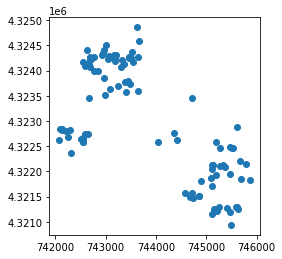

In [64]:
bsu_gpr_sample.plot()

In [61]:
query = session.query(PointData.date)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

# convert to pandas dataframe  
df = query_to_pandas(query, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
dates = sorted(df['date'].unique())
    
print(dates)

[datetime.date(2020, 1, 28), datetime.date(2020, 1, 29), datetime.date(2020, 2, 4), datetime.date(2020, 2, 6), datetime.date(2020, 2, 7), datetime.date(2020, 2, 8), datetime.date(2020, 2, 9)]


Those dates line up with

### ASO data

### Which columns does the ImageData table have?

In [47]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(ImageData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

These are the available columns in the table:
 
* date
* date_accessed
* description
* doi
* instrument
* metadata
* observers
* raster
* registry
* site_name
* time_created
* time_updated
* type
* units



In [3]:
# Locate all that are distinct
airborne_sensors_list = session.query(ImageData.observers).distinct().all()

print('list of airborne sensors by "observer" name: \n', airborne_sensors_list)

list of airborne sensors by "observer" name: 
 [('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


In [4]:
# Query the session using .observers() to generate a list
# Locate all that are distinct
airborne_dataset_types = session.query(ImageData.type).distinct().all()

print('list of airborne sensors by "observer" name')
print(airborne_dataset_types)

list of airborne sensors by "observer" name
[('swe',), ('DEM',), ('insar amplitude',), ('insar correlation',), ('depth',), ('insar interferogram real',), ('insar interferogram imaginary',)]


In [53]:
query = session.query(ImageData.units)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

[('meters',)]


### We want to see the 'swe' 'DEM' and 'depth' data around some area of interest

/tmp/ipykernel_2223/3302178686.py:8: SAWarning: Class ST_Intersects will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = query.all()


ProgrammingError: (psycopg2.errors.UndefinedFunction) function st_intersects(geometry) does not exist
LINE 3: WHERE public.images.observers = 'ASO Inc.' AND ST_Intersects...
                                                       ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.

[SQL: SELECT ST_Value(public.images.raster, ST_SetSRID(ST_MakePoint(%(ST_MakePoint_1)s, %(ST_MakePoint_2)s), %(ST_SetSRID_1)s)) AS "ST_Value_1" 
FROM public.images 
WHERE public.images.observers = %(observers_1)s AND ST_Intersects(ST_SetSRID(ST_MakePoint(%(ST_MakePoint_1)s, %(ST_MakePoint_2)s), %(ST_SetSRID_1)s)) AND public.images.type = %(type_1)s]
[parameters: {'ST_MakePoint_1': 742000, 'ST_MakePoint_2': 4322000, 'ST_SetSRID_1': 26912, 'observers_1': 'ASO Inc.', 'type_1': 'depth'}]
(Background on this error at: https://sqlalche.me/e/14/f405)

## Get the ASO depth measurements for our chosen (large) bounding box

In [54]:
bbox_WSEN = 742000, 4322000, 747000, 4325000
x1, y1, x2, y2 = bbox_WSEN
Polygon()

polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])

In [9]:
session.rollback()

In [6]:
%%time
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")
result = query.count()
print(result)

420
CPU times: user 6.8 ms, sys: 3.49 ms, total: 10.3 ms
Wall time: 126 ms


<timed exec>:6: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)


In [76]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")
result = query.limit(10)
print(result)

SELECT ST_AsTiff(public.images.raster) AS "ST_AsTiff_1" 
FROM public.images 
WHERE public.images.observers = %(observers_1)s AND public.images.type = %(type_1)s AND public.images.date = %(date_1)s 
 LIMIT %(param_1)s


In [77]:
result.all()

/tmp/ipykernel_610/1935894961.py:1: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result.all()


[(<memory at 0x7f4d7f105480>,),
 (<memory at 0x7f4d7f1053c0>,),
 (<memory at 0x7f4d7f105900>,),
 (<memory at 0x7f4d7f105780>,),
 (<memory at 0x7f4d7f1056c0>,),
 (<memory at 0x7f4d7f105540>,),
 (<memory at 0x7f4d7f105600>,),
 (<memory at 0x7f4d7f105a80>,),
 (<memory at 0x7f4d7f105840>,),
 (<memory at 0x7f4d7f1059c0>,)]

In [79]:
datasets = raster_to_rasterio(session, result)
for dataset in datasets:
    print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    print(dataset.bounds)

Raster 152 X 256, Final Res = 3.000000000007304 x 3.000000000007304
BoundingBox(left=759726.0000015992, bottom=4327145.999887465, right=760182.0000016004, top=4327913.999887466)
Raster 256 X 256, Final Res = 3.000000000007304 x 3.000000000007304
BoundingBox(left=737454.000001545, bottom=4326377.999887463, right=738222.0000015468, top=4327145.999887465)
Raster 256 X 256, Final Res = 3.000000000007304 x 3.000000000007304
BoundingBox(left=738222.0000015468, bottom=4326377.999887463, right=738990.0000015487, top=4327145.999887465)
Raster 256 X 256, Final Res = 3.000000000007304 x 3.000000000007304
BoundingBox(left=738990.0000015487, bottom=4326377.999887463, right=739758.0000015505, top=4327145.999887465)
Raster 256 X 256, Final Res = 3.000000000007304 x 3.000000000007304
BoundingBox(left=739758.0000015505, bottom=4326377.999887463, right=740526.0000015524, top=4327145.999887465)
Raster 256 X 256, Final Res = 3.000000000007304 x 3.000000000007304
BoundingBox(left=740526.0000015524, bottom=

In [10]:


bbox_WSEN = 742000, 4322000, 747000, 4325000
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=32612) # which srid is right?
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.count()
print(result)

/tmp/ipykernel_2536/4208347547.py:14: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = query.count()


InternalError: (psycopg2.errors.RaiseException) Raster and geometry do not have the same SRID
CONTEXT:  PL/pgSQL function _st_intersects(geometry,raster,integer) line 7 at RAISE

[SQL: SELECT count(*) AS count_1 
FROM (SELECT ST_AsTiff(public.images.raster) AS "ST_AsTiff_1" 
FROM public.images 
WHERE public.images.observers = %(observers_1)s AND public.images.type = %(type_1)s AND public.images.date = %(date_1)s AND ST_Intersects(public.images.raster, ST_GeomFromWKB(%(ST_GeomFromWKB_1)s, %(ST_GeomFromWKB_2)s))) AS anon_1]
[parameters: {'observers_1': 'ASO Inc.', 'type_1': 'depth', 'date_1': '2020-02-02', 'ST_GeomFromWKB_1': <memory at 0x7f321e499b40>, 'ST_GeomFromWKB_2': 32612}]
(Background on this error at: https://sqlalche.me/e/14/2j85)

In [11]:
wkb_element = from_shape(polygon, srid=26912) # not 32612
print(type(wkb_element))
print(type(wkb_element.ST_AsEWKT()))

<class 'geoalchemy2.elements.WKBElement'>
<class 'geoalchemy2.functions.ST_AsEWKT'>


In [13]:
session.rollback()

In [86]:
# Retrieve some of the ASO Snow Depth tiles
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)

aso_2020_02_02_raster = raster_to_rasterio(session, result)[0].read(1, masked=True)

OperationalError: (psycopg2.OperationalError) SSL SYSCALL error: EOF detected

[SQL: SELECT ST_AsTiff(ST_Clip(ST_Union(public.images.raster), ST_GeomFromWKB(%(ST_GeomFromWKB_1)s, %(ST_GeomFromWKB_2)s))) AS "ST_AsTiff_1" 
FROM public.images 
WHERE public.images.observers = %(observers_1)s AND public.images.type = %(type_1)s AND public.images.date = %(date_1)s AND ST_Intersects(public.images.raster, ST_GeomFromWKB(%(ST_GeomFromWKB_1)s, %(ST_GeomFromWKB_2)s))]
[parameters: {'ST_GeomFromWKB_1': <memory at 0x7f321e499e40>, 'ST_GeomFromWKB_2': 26912, 'observers_1': 'ASO Inc.', 'type_1': 'depth', 'date_1': '2020-02-02'}]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [108]:
datasets = raster_to_rasterio(session, result)
areas = []
for dataset in datasets:
    # print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    # print(dataset.bounds)
    area = dataset.width * dataset.height * dataset.res[0] * dataset.res[1]
    areas.append(area)
    

In [109]:
sum(areas) # area in m^2 of all the rasters. We need to actually clip them and merge them as 1 raster


15027012.00007317

In [113]:
datasets[0]

<open DatasetReader name='/vsimem/27592205-dc76-4409-a39e-a73f07be81d6/27592205-dc76-4409-a39e-a73f07be81d6.tif' mode='r'>

In [ ]:
aso_2020_02_02_raster

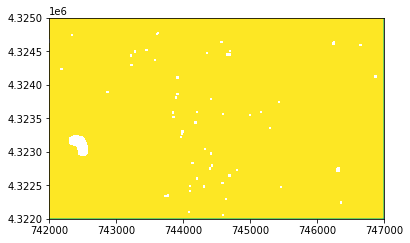

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

In [120]:

aso_2020_02_02_raster = dataset.read(1)
img = show(aso_2020_02_02_raster, transform=dataset.transform)#, cmap='terrain')
plt.colorbar()

In [121]:
aso_2020_02_02_raster.min()

array([[ 7.9664063e-01,  7.8125978e-01,  7.6148438e-01, ...,
         7.2193360e-01,  6.6700196e-01, -9.9990000e+03],
       [ 7.8492188e-01,  7.6880860e-01,  7.4903321e-01, ...,
         7.6124024e-01,  7.4659181e-01, -9.9990000e+03],
       [ 7.5245118e-01,  7.1509767e-01,  7.1045899e-01, ...,
         7.7149415e-01,  7.4244142e-01, -9.9990000e+03],
       ...,
       [ 7.7149415e-01,  8.7940431e-01,  9.3628907e-01, ...,
         9.2579103e-01,  8.7793946e-01, -9.9990000e+03],
       [ 8.9917970e-01,  8.5254884e-01,  8.0518556e-01, ...,
         9.6045899e-01,  9.6167970e-01, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [86]:
40*256*256*3*3 / (1000*1000) # how much area our tiles 
# our bbox is 3000 x 5000 m

23.59296

In [23]:
get_table_attributes(ImageData)

['date',
 'date_accessed',
 'description',
 'doi',
 'instrument',
 'metadata',
 'observers',
 'raster',
 'registry',
 'site_name',
 'time_created',
 'time_updated',
 'type',
 'units']

In [ ]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")
result = query.count()
print(result)

In [38]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

query = session.query(PointData)
# We need to filter

# Filter the query by bounding box (the part that doesn't work)
query = query.filter(gfunc.ST_Within(PointData.geom, wkb_element))

result = query.count()
print(result)

4679570


In [ ]:
session.rollback()

## second dataset lidar


In [138]:
dataset

<open DatasetReader name='/vsimem/59cb0741-1070-4192-ac64-6544ba6f0e51/59cb0741-1070-4192-ac64-6544ba6f0e51.tif' mode='r'>

In [14]:
%%time
# Retrieve some of the ASO Snow Depth tiles
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-13")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)

aso_2020_02_13_raster = raster_to_rasterio(session, result)[0].read(1, masked=True)

[(<memory at 0x7f321e49b7c0>,)]
CPU times: user 60.1 ms, sys: 36.1 ms, total: 96.2 ms
Wall time: 3.33 s


In [23]:
aso_2020_02_13_rio = raster_to_rasterio(session, result)[0]

In [21]:
type(aso_2020_02_13_raster)

numpy.ma.core.MaskedArray

In [ ]:
## assert len(result) == 1, "should have just 1 merged raster"
datasets = raster_to_rasterio(session, result)
dataset = datasets[0]

aso_2020_02_13_raster = rioxarray.open_rasterio(dataset)#.read(1)
# img = show(aso_2020_02_13_raster, transform=dataset.transform)#, cmap='terrain')
# plt.colorbar()

In [143]:

aso_2020_02_13_raster[aso_2020_02_13_raster == -9999] = np.nan
aso_2020_02_02_raster[aso_2020_02_02_raster == -9999] = np.nan
# show(aso_2020_02_13_raster - aso_2020_02_02_raster)
print(np.nanmin(aso_2020_02_13_raster), np.nanmax(aso_2020_02_13_raster))
print(np.nanmin(aso_2020_02_02_raster), np.nanmax(aso_2020_02_02_raster))

NotImplementedError: sub-views are not implemented

In [169]:
type(diff)

numpy.ma.core.MaskedArray

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.296957  , -1.0485332 , -0.8001094 , -0.5516855 , -0.3032617 ,
        -0.05483788,  0.19358595,  0.44200978,  0.6904336 ,  0.93885744,
         1.1872813 ], dtype=float32),
 <a list of 1668 BarContainer objects>)

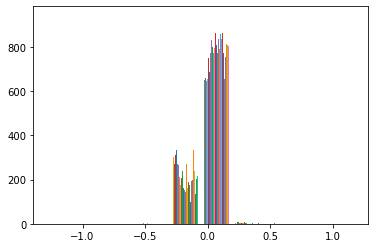

In [182]:
plt.hist(diff)

In [ ]:

m = Map(zoom=6)

right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2019-04-25")
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)
m.add_layer(GeoData(geo_dataframe=gdf))
# m.add_layer(rectangle)

m

Range of changes in the (meters) -1.296957 1.1872813


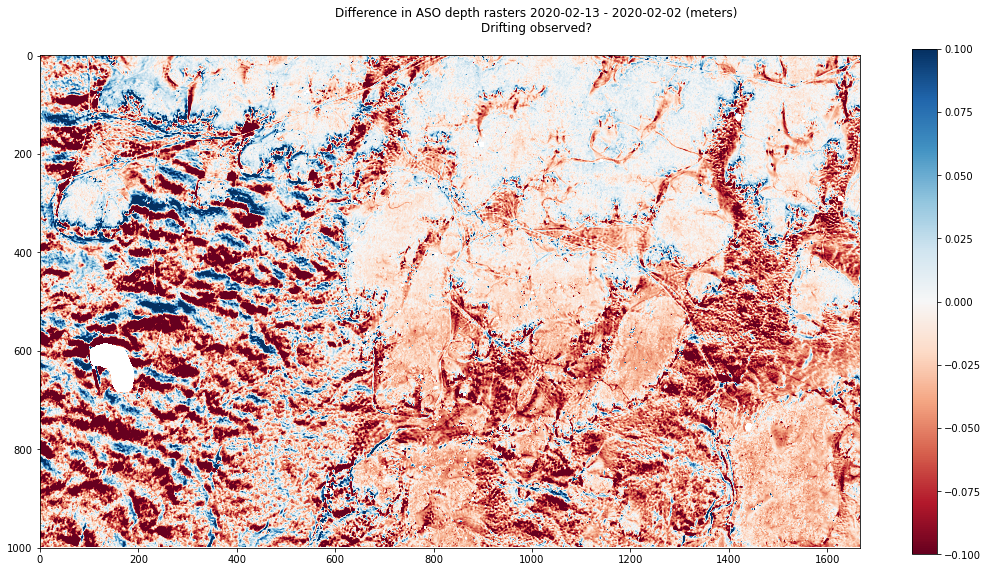

In [77]:
# Redo with rioxarray so we don't lose the coordinate information
fig, ax = plt.subplots(figsize=(15,8))
diff = aso_2020_02_13_raster - aso_2020_02_02_raster

print("Range of changes in the (meters)", np.nanmin(diff), np.nanmax(diff))
# show(diff, ax=ax, cmap="RdBu")
data = ax.imshow(diff, cmap="RdBu")#, vmin=-0.1, vmax=0.1)
fig.suptitle("Difference in ASO depth rasters 2020-02-13 - 2020-02-02 (meters)\nDrifting observed?")

fig.colorbar(data, ax=ax)
plt.tight_layout()
# Got a lot of GPR data where the drifting happened

Range of changes in the (meters) -1.296957 1.1872813


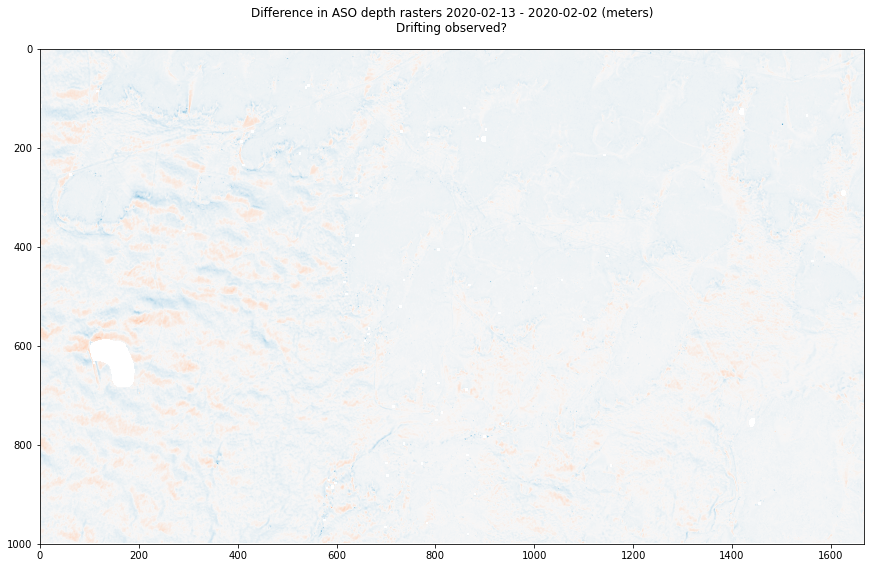

In [17]:
# Redo with rioxarray so we don't lose the coordinate information
fig, ax = plt.subplots(figsize=(15,8))
diff = aso_2020_02_13_raster - aso_2020_02_02_raster
# diff_filt = np.where(diff, diff < 0)
# diff_filt = diff_filt.where(diff_filt, diff_filt > -0.5)
# print(diff_filt.shape)
# diff_filt.reshape(diff.shape)

print("Range of changes in the (meters)", np.nanmin(diff), np.nanmax(diff))
show(diff, ax=ax, cmap="RdBu")
fig.suptitle("Difference in ASO depth rasters 2020-02-13 - 2020-02-02 (meters)\nDrifting observed?")

# plt.colorbar()
plt.tight_layout()
# Got a lot of GPR data where the drifting happened

In [20]:
aso_2020_02_02_raster.xy

AttributeError: 'MaskedArray' object has no attribute 'xy'

In [179]:

m = Map(zoom=6)

right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2019-04-25")
rectangle = ImageOverlay(diff, bounds=dataset.bounds)
left_layer = rectangle #TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)
# m.add_layer(GeoData(geo_dataframe=gdf))
# m.add_layer(rectangle)

m

TypeError: Layer.__init__() takes 1 positional argument but 2 were given

In [180]:
ImageOverlay?

Init signature: ImageOverlay(*args: Any, **kwargs: Any) -> Any
Docstring:     
ImageOverlay class.

Image layer from a local or remote image file.

Attributes
----------
url: string, default ""
    Url to the local or remote image file.
bounds: list, default [0., 0]
    SW and NE corners of the image.
attribution: string, default ""
    Image attribution.
Init docstring: Public constructor
File:           /srv/conda/envs/notebook/lib/python3.10/site-packages/ipyleaflet/leaflet.py
Type:           MetaHasTraits
Subclasses:     


In [172]:
diff.shape

(1001, 1668)

In [173]:
1001*1668*3*3

15027012

In [17]:
session.rollback()

## find the raster value at a given point (GPR point)

In [24]:
# 
x,y = 742000, 4322000#, 747000, 4325000
point = func.ST_SetSRID(func.ST_MakePoint(x,y), 26912)
query = session.query(func.ST_Value(ImageData.raster, point), ImageData.date, ImageData.id, ImageData.type)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(gfunc.ST_Intersects(ImageData.raster, point))
query = query.filter(ImageData.type.in_(["depth", "swe"]))# == "depth")

result = query.all()
print(result)

[(0.5974472761154175, datetime.date(2020, 2, 13), 155410, 'depth'), (0.7268164157867432, datetime.date(2020, 2, 2), 154990, 'depth'), (0.2043323665857315, datetime.date(2020, 2, 2), 154681, 'swe'), (0.1875717043876648, datetime.date(2020, 2, 13), 154683, 'swe')]


In [33]:
%%time
raster_values_at_points = []
for x in range(742000, 747000, 10):
    for y in range(4322000, 4325000, 10):
        point = func.ST_SetSRID(func.ST_MakePoint(x,y), 26912)
        query = session.query(func.ST_Value(ImageData.raster, point), ImageData.date, ImageData.id, ImageData.type)
        query = query.filter(ImageData.observers == "ASO Inc.")
        query = query.filter(gfunc.ST_Intersects(ImageData.raster, point))
        query = query.filter(ImageData.type.in_(["depth", "swe"]))# == "depth")
        
        result = query.all()
        raster_values_at_points.append(result)
        # print(f"{x} {y} = {result}\n")
        

OperationalError: (psycopg2.OperationalError) server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

[SQL: SELECT ST_Value(public.images.raster, ST_SetSRID(ST_MakePoint(%(ST_MakePoint_1)s, %(ST_MakePoint_2)s), %(ST_SetSRID_1)s)) AS "ST_Value_1", public.images.date AS public_images_date, public.images.id AS public_images_id, public.images.type AS public_images_type 
FROM public.images 
WHERE public.images.observers = %(observers_1)s AND ST_Intersects(public.images.raster, ST_SetSRID(ST_MakePoint(%(ST_MakePoint_1)s, %(ST_MakePoint_2)s), %(ST_SetSRID_1)s)) AND public.images.type IN (%(type_1_1)s, %(type_1_2)s)]
[parameters: {'ST_MakePoint_1': 742110, 'ST_MakePoint_2': 4324990, 'ST_SetSRID_1': 26912, 'observers_1': 'ASO Inc.', 'type_1_1': 'depth', 'type_1_2': 'swe'}]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [34]:
len(raster_values_at_points)

3599

## The stuff from post it notes about getting the data

In [43]:
aso_2020_02_13_rio.bounds

BoundingBox(left=741999.000001556, bottom=4321997.9998874515, right=747003.0000015682, top=4325000.999887459)

In [64]:
x, y = 745678, 4324321
pixel_idx_x, pixel_idx_y = aso_2020_02_13_rio.index(x, y) # origin is top left or bottom left?
pixel_center_x, pixel_center_y = aso_2020_02_13_rio.xy(pixel_idx_x, pixel_idx_y)
print(f"Started with the GPR point x, y = ({x}, {y})")
print(f"Nearest pixel is at row {pixel_idx_y} and column {pixel_idx_x} \n\t-> centered at ({pixel_center_x}, {pixel_center_y})")
print(f"\tPixel value for aso 02-02-20 depth is: ???")
print(f"\tPixel value for aso 02-02-20 swe is: ???")
print(f"\tPixel value for aso 02-13-20 depth is: ", aso_2020_02_13_raster[pixel_idx_x, pixel_idx_y])
print(f"\tPixel value for aso 02-13-20 swe is: ???")

Started with the GPR point x, y = (745678, 4324321)
Nearest pixel is at row 1226 and column 226 
	-> centered at (745678.500001565, 4324321.499887457)
	Pixel value for aso 02-02-20 depth is: ???
	Pixel value for aso 02-02-20 swe is: ???
	Pixel value for aso 02-13-20 depth is:  0.9035996
	Pixel value for aso 02-13-20 swe is: ???


In [61]:
aso_2020_02_13_raster[0,0]

0.7431992

In [104]:
%%time
values = []
for x in range(742000, 747000, 1):
    for y in range(4322000, 4325000, 10):
        pixel_idx_x, pixel_idx_y = aso_2020_02_13_rio.index(x, y) # origin is top left or bottom left?
        pixel_center_x, pixel_center_y = aso_2020_02_13_rio.xy(pixel_idx_x, pixel_idx_y)
        value = aso_2020_02_13_raster[pixel_idx_x, pixel_idx_y]
        values.append((x,y,value))
        # print(f"Started with the GPR point x, y = ({x}, {y})")
        # print(f"Nearest pixel is at row {pixel_idx_y} and column {pixel_idx_x} \n\t-> centered at ({pixel_center_x}, {pixel_center_y})")
        # print(f"\tPixel value for aso 02-02-20 depth is: ???")
        # print(f"\tPixel value for aso 02-02-20 swe is: ???")
        # print(f"\tPixel value for aso 02-13-20 depth is: ", aso_2020_02_13_raster[pixel_idx_x, pixel_idx_y])
        # print(f"\tPixel value for aso 02-13-20 swe is: ???")
        # print(20*"-")
        
print(len(values))

1500000
CPU times: user 41.6 s, sys: 90.2 ms, total: 41.7 s
Wall time: 41.7 s


In [105]:
values[:5]

[(742000, 4322000, masked),
 (742000, 4322010, 0.5117539),
 (742000, 4322020, 0.7988633),
 (742000, 4322030, 0.768834),
 (742000, 4322040, 0.5718125)]

In [106]:
gdf = gpd.read_file("GPR_ALL.csv")
gdf.head()

,field_1,geom,easting,northing,twt,date,geometry
0,0,POINT (743148.4280291862 4324346.7150880415),743148.4280291862,4324346.7150880415,8.3,2020-01-28,None
1,1,POINT (743148.4040291404 4324346.714088032),743148.4040291404,4324346.714088032,8.3,2020-01-28,None
2,2,POINT (743148.2910291193 4324346.702088035),743148.2910291193,4324346.702088035,8.3,2020-01-28,None
3,3,POINT (743148.3820291588 4324346.713088031),743148.3820291588,4324346.713088031,8.3,2020-01-28,None
4,4,POINT (743148.3610291365 4324346.711088029),743148.3610291365,4324346.711088029,8.3,2020-01-28,None


In [120]:
xy = gdf[["easting", "northing"]].head().values.tolist()

In [121]:
xy

[['743148.4280291862', '4324346.7150880415'],
 ['743148.4040291404', '4324346.714088032'],
 ['743148.2910291193', '4324346.702088035'],
 ['743148.3820291588', '4324346.713088031'],
 ['743148.3610291365', '4324346.711088029']]

In [156]:
def f(row):
    # print(row)
    x,y = float(row["easting"]), float(row["northing"])
    pixel_idx_x, pixel_idx_y = aso_2020_02_13_rio.index(x, y) # origin is top left or bottom left?
    pixel_center_x, pixel_center_y = aso_2020_02_13_rio.xy(pixel_idx_x, pixel_idx_y)
    value = aso_2020_02_13_raster[pixel_idx_x, pixel_idx_y]
    # print(value)
    return value

In [131]:
values = []
for coord in xy[:10]:
    # print(coord)
    x,y=coord
    x = float(x)
    y = float(y)
    print(x,y)
    pixel_idx_x, pixel_idx_y = aso_2020_02_13_rio.index(x, y) # origin is top left or bottom left?
    pixel_center_x, pixel_center_y = aso_2020_02_13_rio.xy(pixel_idx_x, pixel_idx_y)
    value = aso_2020_02_13_raster[pixel_idx_x, pixel_idx_y]
    # if (not (value > 0))
    values.append((x,y,pixel_idx_x, pixel_idx_y,pixel_center_x,pixel_center_y,value))
print(values)

743148.4280291862 4324346.7150880415
743148.4040291404 4324346.714088032
743148.2910291193 4324346.702088035
743148.3820291588 4324346.713088031
743148.3610291365 4324346.711088029
[(743148.4280291862, 4324346.7150880415, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595), (743148.4040291404, 4324346.714088032, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595), (743148.2910291193, 4324346.702088035, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595), (743148.3820291588, 4324346.713088031, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595), (743148.3610291365, 4324346.711088029, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595)]


In [137]:
gdf.head()

,field_1,geom,easting,northing,twt,date,geometry
0,0,POINT (743148.4280291862 4324346.7150880415),743148.4280291862,4324346.7150880415,8.3,2020-01-28,None
1,1,POINT (743148.4040291404 4324346.714088032),743148.4040291404,4324346.714088032,8.3,2020-01-28,None
2,2,POINT (743148.2910291193 4324346.702088035),743148.2910291193,4324346.702088035,8.3,2020-01-28,None
3,3,POINT (743148.3820291588 4324346.713088031),743148.3820291588,4324346.713088031,8.3,2020-01-28,None
4,4,POINT (743148.3610291365 4324346.711088029),743148.3610291365,4324346.711088029,8.3,2020-01-28,None


In [162]:
%%time
gdf["aso_snow_depth_2020_02_13"] = gdf.apply(f, axis=1)

CPU times: user 1min 12s, sys: 219 ms, total: 1min 12s
Wall time: 1min 12s


In [176]:
len(gdf)

1549196

In [188]:
gdf_small = gdf.head(50)

In [189]:
len(gdf_small[(gdf_small["aso_snow_depth_2020_02_13"] > 0) | (gdf_small["aso_snow_depth_2020_02_13"] <= 0)])


50

In [190]:
gdf_without_masked = gdf[(gdf["aso_snow_depth_2020_02_13"] > 0) | (gdf["aso_snow_depth_2020_02_13"] <= 0)]
len(gdf_without_masked)

1548996

In [196]:
gdf_without_masked.geometry = gpd.points_from_xy(gdf_without_masked["easting"], gdf_without_masked["northing"])

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [197]:
gdf_without_masked

,field_1,geom,easting,northing,twt,date,geometry,aso_snow_depth_2020_02_13
0,0,POINT (743148.4280291862 4324346.7150880415),743148.4280291862,4324346.7150880415,8.3,2020-01-28,POINT (743148.428 4324346.715),0.945836
1,1,POINT (743148.4040291404 4324346.714088032),743148.4040291404,4324346.714088032,8.3,2020-01-28,POINT (743148.404 4324346.714),0.945836
2,2,POINT (743148.2910291193 4324346.702088035),743148.2910291193,4324346.702088035,8.3,2020-01-28,POINT (743148.291 4324346.702),0.945836
3,3,POINT (743148.3820291588 4324346.713088031),743148.3820291588,4324346.713088031,8.3,2020-01-28,POINT (743148.382 4324346.713),0.945836
4,4,POINT (743148.3610291365 4324346.711088029),743148.3610291365,4324346.711088029,8.3,2020-01-28,POINT (743148.361 4324346.711),0.945836
...,...,...,...,...,...,...,...,...
1549191,1549191,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),0.660191
1549192,1549192,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),0.660191
1549193,1549193,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),0.660191
1549194,1549194,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.78,2020-02-04,POINT (746608.786 4324145.781),0.660191


In [246]:
# box is majority of the gpr data
# first 10000 points is Tate's first spiral
# 20-190cm sounds about right for snow depth
# Two-way travel time + snow pit density nearby is another fusion step
# Then we can do the
# between 1-93 in the first 10000
# keep the ones on skis together with those with the snowmobile
# Investigate the ones where there are way more in 1 pixel than I am expecting

<AxesSubplot:>

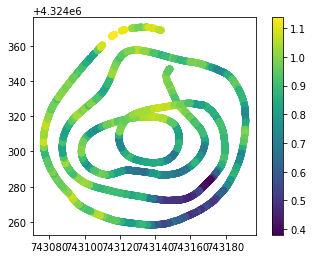

In [214]:
gdf_without_masked.head(10000).plot(column="aso_snow_depth_2020_02_13", legend=True)

In [235]:
counts = grouped.count()


In [249]:
counts.max()

field_1     1947
geom        1947
easting     1947
northing    1947
twt         1947
date        1947
geometry    1947
dtype: int64

In [247]:
counts.idxmax()

field_1     0.983189
geom        0.983189
easting     0.983189
northing    0.983189
twt         0.983189
date        0.983189
geometry    0.983189
dtype: float64

In [234]:
grouped = gdf_without_masked.groupby("aso_snow_depth_2020_02_13")

<AxesSubplot:>

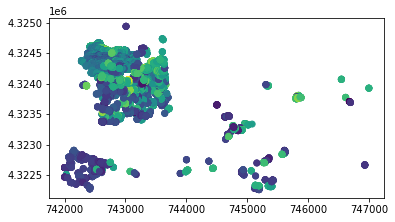

In [245]:
grouped.head().plot(column="aso_snow_depth_2020_02_13")

<AxesSubplot:>

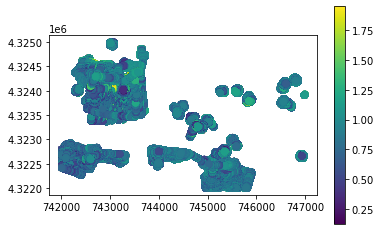

In [212]:
gdf_without_masked.plot(column="aso_snow_depth_2020_02_13", legend=True)

In [207]:
gdf_without_masked["aso_snow_depth_2020_02_13"] = gdf_without_masked["aso_snow_depth_2020_02_13"].astype(float)

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [180]:
len(gdf[gdf["aso_snow_depth_2020_02_13"].notna()])

1549196

In [167]:
gdf.groupby("date").count()

,field_1,geom,easting,northing,twt,geometry,aso_snow_depth_2020_02_13
date,,,,,,,
2020-01-28,531650,531650,531650,531650,531650,0,531650
2020-01-29,264401,264401,264401,264401,264401,0,264401
2020-01-30,57964,57964,57964,57964,57964,0,57964
2020-01-31,165227,165227,165227,165227,165227,0,165227
2020-02-01,134370,134370,134370,134370,134370,0,134370
2020-02-04,171478,171478,171478,171478,171478,0,171478
2020-02-05,68710,68710,68710,68710,68710,0,68710
2020-02-06,19763,19763,19763,19763,19763,0,19763
2020-02-07,38305,38305,38305,38305,38305,0,38305


In [166]:
gdf.groupby("aso_snow_depth_2020_02_13").count()

TypeError: unhashable type: 'MaskedConstant'

In [132]:
for v in values:
    print(v)

(743148.4280291862, 4324346.7150880415, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595)
(743148.4040291404, 4324346.714088032, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595)
(743148.2910291193, 4324346.702088035, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595)
(743148.3820291588, 4324346.713088031, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595)
(743148.3610291365, 4324346.711088029, 218, 383, 743149.5000015588, 4324345.499887457, 0.94583595)


<AxesSubplot:>

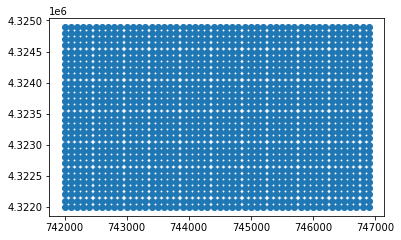

In [100]:
gdf = gpd.GeoDataFrame(values)
gdf.geometry = gpd.points_from_xy(gdf[0],gdf[1])
gdf.plot()

In [82]:
aso_2020_02_13_raster.rio.to_raster("aso_depth_2020_02_13.tif")

AttributeError: 'MaskedArray' object has no attribute 'rio'

In [83]:
import rasterio

In [85]:
with rasterio.open("aso_depth_2020_02_13.tif", "w") as dst:
    dst.write(aso_2020_02_13_raster, 1)

TypeError: Integer width and height are required.